In [15]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [16]:
import tensorflow as tf
#import tensorflow as tf
#tf.config.list_physical_devices('GPU')

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 289453460426000826
xla_global_id: -1
]


In [18]:
from tensorflow.keras.regularizers import l2
#import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
np.set_printoptions(suppress=True)
from scipy.io import loadmat
import argparse
import json
import numpy as np
import os




from models import DeepConditionalModel
from inn_utils import (train_online_ml, compute_performance_metrics, train_online_kl, 
                       train_online_heteroscedastic, train_online_iaf)
from process_models import simulate_model_params, simulate_model, simulate_model_params, load_test_model
from viz import (plot_true_est_scatter, plot_true_est_posterior, 
                 plot_losses, plot_sbc, plot_performance_metrics, plot_contraction,
                 plot_true_est_posterior_samples)
import diagnostics as diag

In [19]:
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Conditional Invertible Neural Network (cINN)

## Summary network for the Ricker model
<p>We use an LSTM for the observed time-series data.</p>

In [21]:
class SequenceNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self, h_lstm_dim=32, h_dense_dim=64):
        super(SequenceNetwork, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(h_lstm_dim)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
        ])
    
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

<p>We will also append a dummy noise parameter to the true parameter vector.</p>

In [22]:
def add_noise_var(X_batch, theta_batch):
    """
    Adds a column of uniform noise to the true parameter values.
    """
    
    noise_col = tf.random.uniform(shape=(theta_batch.shape[0], 1))
    theta_batch = tf.concat((theta_batch, noise_col), axis=-1)
    return X_batch, theta_batch

## Initialization 

In [23]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64, 64, 64],
    #'n_units': [10, 10, 10, 10, 10],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
train = False
param_names = [r'$\alpha$', r'$\beta$', r'$\Lambda$', r's',r'\Theta']
theta_dim = 5
global_step = tf.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 10
n_test = 300
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 2000
decay_rate = 0.1
clip_value = 5.
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
#earning_rate = tf.compat.v1.train.polynomial_decay(starter_learning_rate,global_step=tf.Variable(0, trainable=False), decay_steps=10000,end_learning_rate=0.5,power=0.5,cycle=False,name=None)

### Create test data

(64, 170)
(64, 5)
(64, 170)
(64, 5)


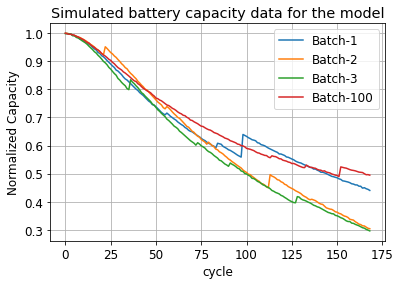

In [36]:
# For scatter
#simulate_model(100, n_points=500, to_tensor=False)
X_sim, theta_sim = simulate_model()
 
np.save('model_X.npy', X_sim)
np.save('model_theta.npy', theta_sim)

print(X_sim.shape)
print(theta_sim.shape)
X_test, theta_test = load_test_model()

print(X_test.shape)
print(theta_test.shape)

plt.plot(X_sim[0][1:],label='Batch-1')
plt.plot(X_sim[1][1:],label='Batch-2')
plt.plot(X_sim[2][1:],label='Batch-3')
'''plt.plot(X_sim[3][1:],label='Batch-4')
plt.plot(X_sim[4][1:],label='Batch-5')
plt.plot(X_sim[6][1:],label='Batch-6')'''
plt.plot(X_sim[63][1:],label='Batch-100')
plt.title("Simulated battery capacity data for the model")
plt.xlabel('cycle')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.grid()
plt.show()

### Create networks

In [37]:
#summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

### Plot performance of untrained networks

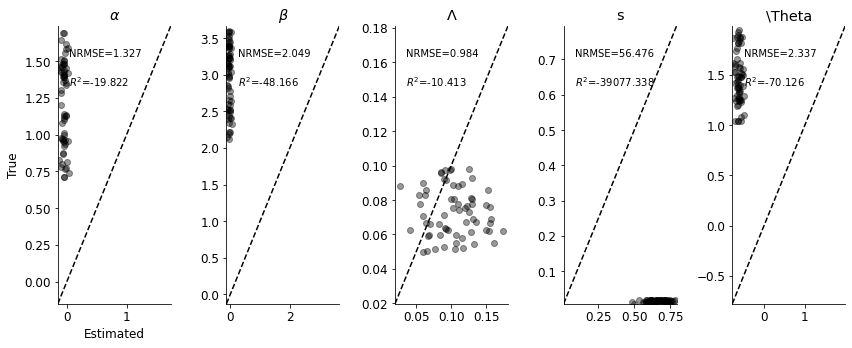

In [38]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names[:5], figsize=(12, 5))


### Checkpoint manager

In [39]:

checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/model', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")


Restored from ./checkpoints/model\ckpt-435


## Train the model

In [40]:
%%time

for ep in range(1, epochs+1):
        with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
            losses = train_online_ml(model, optimizer, simulate_model, iterations_per_epoch, 
                                    batch_size, p_bar, clip_value=clip_value, 
                                    global_step=global_step, transform=add_noise_var)

            # Store checkpoint
            manager.save()
            

    
        
        

<timed exec>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 8h 33min 56s


## Evaluate the trained model

### Posterior means (recovery)

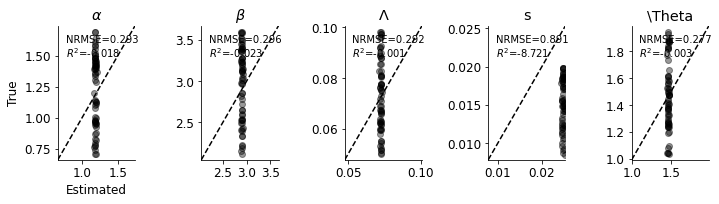

In [41]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names[:5], 
                      figsize=(10, 3), filename='Model')

Load the observed battery capacity data

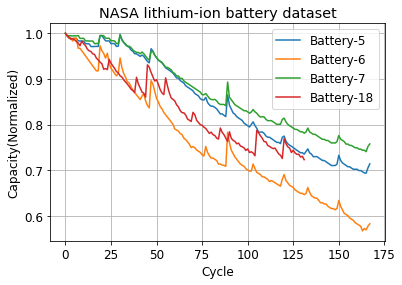

In [61]:
def load_battery(filename):
    # data is stored as a hierarchy of structs
    # we load with `squeeze_me` to simplify things a little
    data = loadmat(filename, squeeze_me=True)

    # the root variable is the name of the battery set
    # the next key is `cycle`
    # `squeeze_me` ends up with a 0-dim array somehow
    # so we index with and empty tuple to get the data
    events = data[list(data.keys())[-1]]["cycle"][()]

    # only the discharge events have the capacity data
    discharge_capacities = [
        e["data"]["Capacity"][()] for e in events if e["type"] == "discharge"
    ]

    # convert it back to an np.array
    discharge_capacities = np.array(discharge_capacities)
    # convert capacity to percentage
    discharge_capacities /= discharge_capacities[0]
    return discharge_capacities


filename1 = r"C:\Users\lra240\Desktop\2-Summer research 2022\6-Data\BatteryAgingARC-FY08Q4\B0005.mat"
filename2 = r"C:\Users\lra240\Desktop\2-Summer research 2022\6-Data\BatteryAgingARC-FY08Q4\B0006.mat"
filename3 = r"C:\Users\lra240\Desktop\2-Summer research 2022\6-Data\BatteryAgingARC-FY08Q4\B0007.mat"
filename4 = r"C:\Users\lra240\Desktop\2-Summer research 2022\6-Data\BatteryAgingARC-FY08Q4\B0018.mat"


data1 = load_battery(filename1)
data2 = load_battery(filename2)
data3 = load_battery(filename3)
data4 = load_battery(filename4)


plt.plot(data1, label='Battery-5')
plt.plot(data2, label='Battery-6')
plt.plot(data3, label='Battery-7')
plt.plot(data4, label='Battery-18')
plt.title("NASA lithium-ion battery dataset")
plt.xlabel('Cycle')
plt.ylabel('Capacity(Normalized)')
plt.legend()
plt.grid()
plt.show()


#tf.convert_to_tensor(X[:, :], dtype=tf.float32)

In [434]:
data = torch.tensor(data4, dtype=torch.float64)

#parameter definition
N_Cuts = 100
noise_std = 0.001
n_samples = 100

#get the output smaples of posterior
p_aproximate = model.sample( data, n_samples, to_numpy=True, training=False)


print(p_aproximate.shape)

(100, 132, 5)


In [388]:
'''
#Predict the model for one sample
#C
import argparse
import json
import numpy as np
import os
import pyro
import pyro.distributions as dist
import torch
from dataset import load_battery
import time

# title MCMC Batch Training w/ Regen
pyro.set_rng_seed(1)


def model_predict(data,N_Cuts,p_aproximate,noise_std):
    predRange = np.arange(N_Cuts,len(data),1) 
    state_history = torch.zeros((len(predRange),))
    measurement_history = torch.zeros((len(predRange),))
    j = 0

    for i in predRange:
        param_a = torch.tensor(p_aproximate[:,i,0], dtype=torch.float64)
        param_b = torch.tensor(p_aproximate[:,i,1], dtype=torch.float64)
        poisson_rate = torch.tensor(p_aproximate[:,i,2], dtype=torch.float64)
        #poisson_rate_int = poisson_rate.item()
        regen_gamma_beta = torch.tensor(p_aproximate[:,i,4], dtype=torch.float64)
        regen_gamma_mu = torch.tensor(p_aproximate[:,i,3], dtype=torch.float64)
        Ri = np.random.gamma(regen_gamma_beta.item(), regen_gamma_mu.item())
        
        if i == N_Cuts: #
            x_prediction = torch.tensor(data[N_Cuts-1])
        elif i % round(1 / poisson_rate.item()) == 0 and round(1 / poisson_rate.item()) != 0 :
            x_prediction = (state_history[j - 1]- (param_a * param_b * i) / (10000 + (param_b * i) ** 2) + Ri)
            #print(i)
            #print('Spike')
            #print(Ri)     
        else:
            x_prediction = state_history[j - 1] - (param_a * param_b * i) / (10000 + (param_b * i) ** 2)
            
        next_observed = pyro.sample(f"meas_{j}", dist.Normal(x_prediction, torch.tensor(noise_std)))

        state_history[j] = x_prediction
        measurement_history[j] = next_observed
        j +=1
    return predRange, state_history, measurement_history 
'''

'\n#Predict the model for one sample\n#C\nimport argparse\nimport json\nimport numpy as np\nimport os\nimport pyro\nimport pyro.distributions as dist\nimport torch\nfrom dataset import load_battery\nimport time\n\n# title MCMC Batch Training w/ Regen\npyro.set_rng_seed(1)\n\n\ndef model_predict(data,N_Cuts,p_aproximate,noise_std):\n    predRange = np.arange(N_Cuts,len(data),1) \n    state_history = torch.zeros((len(predRange),))\n    measurement_history = torch.zeros((len(predRange),))\n    j = 0\n\n    for i in predRange:\n        param_a = torch.tensor(p_aproximate[:,i,0], dtype=torch.float64)\n        param_b = torch.tensor(p_aproximate[:,i,1], dtype=torch.float64)\n        poisson_rate = torch.tensor(p_aproximate[:,i,2], dtype=torch.float64)\n        #poisson_rate_int = poisson_rate.item()\n        regen_gamma_beta = torch.tensor(p_aproximate[:,i,4], dtype=torch.float64)\n        regen_gamma_mu = torch.tensor(p_aproximate[:,i,3], dtype=torch.float64)\n        Ri = np.random.gamma(r

In [423]:
def RMSE(predictions, targets):
    return np.sqrt(np.mean((predictions.numpy()-targets.numpy())**2)) 

In [436]:
print(len(measurement_history))
print(len(np.arange(N_Cuts,len(data),1)))
print(len(data[N_Cuts:len(data)]))
predRange = np.arange(N_Cuts,len(data),1) 
print(len(predRange))

68
32
32
32


In [437]:
#Predict the model for n_samples

import argparse
import json
import numpy as np
import os
import pyro
import pyro.distributions as dist
import torch
from dataset import load_battery
import time

# title MCMC Batch Training w/ Regen
pyro.set_rng_seed(1)


def model_predict(data,N_Cuts,p_aproximate,noise_std):
    predRange = np.arange(N_Cuts,len(data),1) 
    state_history = torch.zeros((len(predRange),n_samples))   
    measurement_history = torch.zeros((len(predRange),n_samples))   
    j = 0 # counter

    for i in predRange:
        for s in range(n_samples): #s - counter
            param_a = torch.tensor(p_aproximate[s,i,0], dtype=torch.float64)
            param_b = torch.tensor(p_aproximate[s,i,1], dtype=torch.float64)*1.5 # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            poisson_rate = torch.tensor(p_aproximate[s,i,2], dtype=torch.float64)
            #poisson_rate_int = poisson_rate.item()
            regen_gamma_beta = torch.tensor(p_aproximate[s,i,4], dtype=torch.float64)*0.2 # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            regen_gamma_mu = torch.tensor(p_aproximate[s,i,3], dtype=torch.float64)*0.6 # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            Ri = np.random.gamma(regen_gamma_beta.item(), np.absolute(regen_gamma_mu.item())) # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            #Ri = 0
            
            if i == N_Cuts: 
                x_prediction = torch.tensor(data[N_Cuts-1])
            elif i % round(1 / poisson_rate.item()) == 0 and round(1 / poisson_rate.item()) != 0 :
                x_prediction = (state_history[j - 1, s]- (param_a * param_b * i) / (10000 + (param_b * i) ** 2) + Ri)
                #print(i)
                #print('Spike')
                #print(Ri)     
            else:
                x_prediction = state_history[j - 1, s] - (param_a * param_b * i) / (10000 + (param_b * i) ** 2)
                
            next_observed = pyro.sample(f"meas_{j}", dist.Normal(x_prediction, torch.tensor(noise_std)))

            state_history[j,s] = x_prediction
            measurement_history[j,s] = next_observed
        j +=1
    return predRange, state_history, measurement_history 

C:\Users\lra240\AppData\Local\Temp/ipykernel_27444/4162014718.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_prediction = torch.tensor(data[N_Cuts-1])


(32,)


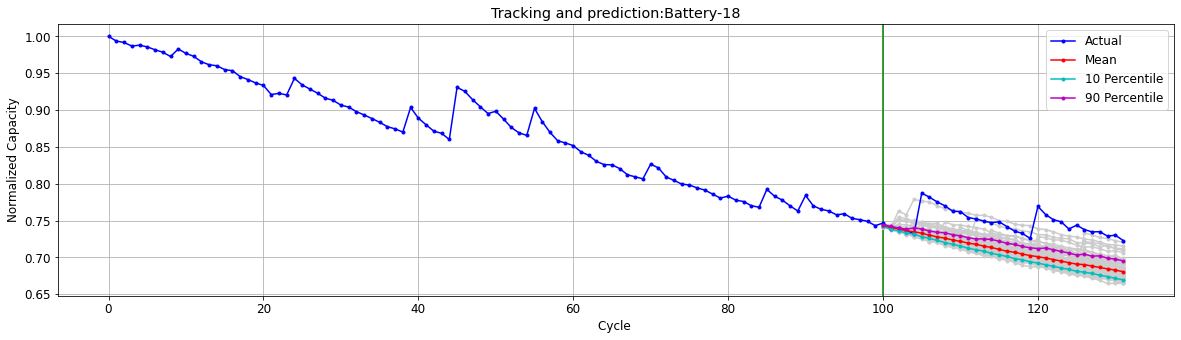

RMSE of tracking:   0.04104018204932098


In [445]:
#traking
predRange, state_history, measurement_history = model_predict(data, N_Cuts, p_aproximate, noise_std)

state_history_mean = tf.reduce_mean(state_history, 1)
measurement_history_mean = tf.reduce_mean(measurement_history, 1)
measurement_history_10p = np.percentile( measurement_history.numpy(), 10, 1)
measurement_history_25p = np.percentile( measurement_history.numpy(), 25, 1)
measurement_history_75p = np.percentile( measurement_history.numpy(), 75, 1)
measurement_history_90p = np.percentile( measurement_history.numpy(), 90, 1)

print(measurement_history_75p.shape)

plt.figure(figsize=(20,5))
plt.axvline(x = N_Cuts,color = 'g')
for s in range(n_samples):
    plt.plot(predRange, measurement_history[:, s], color=[0.8,0.8,0.8], marker ='.') # the prediction
plt.plot(np.arange(len(data)),data,color='b', marker ='.',label='Actual')
plt.plot(predRange, measurement_history_mean, 'r', marker ='.',label='Mean') # the prediction
plt.plot(predRange, measurement_history_10p, 'c', marker ='.',label='10 Percentile') # the prediction
plt.plot(predRange, measurement_history_90p, 'm', marker ='.',label='90 Percentile') # the prediction

plt.title("Tracking and prediction:Battery-18")
plt.xlabel('Cycle ')
plt.ylabel('Normalized Capacity')
plt.legend()
#plt.figure(figsize=(100, 100))
plt.grid()
plt.show()

print(f'RMSE of tracking:   {RMSE(measurement_history_mean, data[N_Cuts:len(data)])}')
